# Visualizing NDT & Paris-Traceroute in Africa

## Setup

This Jupyter notebook visualizes M-Lab test data in Africa. Using BigQuery, we select NDT or paris-traceroute data from clients in Africa. Then, using world map data from Natural Earth and the GeoDataFrame Python packages, we plot the African data using GEO-location hints.

* Install [Jupyter](http://jupyter.org/install)
* Install [gcloud SDK](https://cloud.google.com/sdk/downloads) 
* Setup gcloud SDK

```
# Authenticate your account.
gcloud auth login

# Set default project.
gcloud config set project measurement-lab
```

* Install [google-cloud-bigquery](https://pypi.org/project/google-cloud-bigquery/) package:
  
```
pip install --upgrade google-cloud-bigquery
```

* Install [GeoPandas](http://geopandas.org/install.html)

```
pip install geopandas PySAL descartes
```

* Download Natural Earth "Admin 0 - Countries" dataset

  https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-countries/
  
* Unzip ne_10m_admin_0_countries.zip 

```
cd ~/Downloads
unzip ne_10m_admin_0_countries.zip
```

* Start Jupyter

```
jupyter-notebook
```
 
## References

* Matplotlib - https://matplotlib.org/contents.html
* Pandas - https://pandas.pydata.org/pandas-docs/stable/api.html 
* BigQuery - https://cloud.google.com/bigquery/docs/reference/standard-sql/functions-and-operators 
* GeoPandas - http://geopandas.org/index.html

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
from shapely import geometry

# Set project explicitly in the environment to suppress some warnings.
os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

# Load M-Lab site metadata including site latitude & longitude.
mlab_sites_config = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

# Short list of metros in Africa, for convenience.
african_sites = ['jnb', 'cpt', 'mpm', 'tnr', 'nbo', 'los', 'acc', 'tun']

# Load the Natural Earth country shapes file.
shapefile = os.path.expanduser('~/Downloads/ne_10m_admin_0_countries.shp')

# Number of colors to use when coloring maps.
colors = 10

# Default figure size. W x H.
figsize = (16, 10)

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=600):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [4]:
# Load shape data.
globe_raw = gpd.read_file(shapefile)

# Select the global information (except Antarctica).
globe = globe_raw[['ISO_A2', 'CONTINENT', 'geometry']].to_crs('+proj=longlat')
globe = globe[globe.CONTINENT != 'Antarctica']
# Add a new column with a default value of zero to plot empty country maps.
globe['default'] = 0

# Select only Africa.
africa = globe[globe.CONTINENT == 'Africa'].copy()
africa['default'] = 0
africa.sample(5)

,ISO_A2,CONTINENT,geometry,default
31,CG,Africa,"POLYGON ((18.62638716600009 3.476868998000072,...",0
132,UG,Africa,POLYGON ((30.47178584300013 -1.066836591999916...,0
14,SS,Africa,"POLYGON ((35.92083540900012 4.619331563000102,...",0
83,GN,Africa,POLYGON ((-13.30109615799995 9.041489976000037...,0
32,CD,Africa,(POLYGON ((18.62638716600009 3.476868998000072...,0


# NDT Clients in Africa

In [5]:
rates_df = run_query("""
SELECT
  connection_spec.client_geolocation.country_name as country_name,
  connection_spec.client_geolocation.country_code as country_code,
  COUNT(*) as count,
  AVG(8 * (web100_log_entry.snap.HCThruOctetsAcked /
      (web100_log_entry.snap.SndLimTimeRwin +
       web100_log_entry.snap.SndLimTimeCwnd +
       web100_log_entry.snap.SndLimTimeSnd))) AS download_Mbps
       
FROM
  `measurement-lab.ndt.base`
WHERE
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND connection_spec.client_geolocation.continent_code = "AF"

  AND connection_spec.data_direction = 1
  AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000
  AND (web100_log_entry.snap.SndLimTimeRwin +
    web100_log_entry.snap.SndLimTimeCwnd +
    web100_log_entry.snap.SndLimTimeSnd) < 600000000
  AND web100_log_entry.snap.CongSignals > 0
  AND (web100_log_entry.snap.State = 1 OR
    (web100_log_entry.snap.State >= 5 AND
    web100_log_entry.snap.State <= 11))
  
GROUP BY
  country_code, country_name
ORDER BY
 country_name, country_code, count desc
""")

/usr/local/google/home/soltesz/.local/lib/python2.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/.
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [6]:
rates_df.sample(5)

,count,country_code,country_name,download_Mbps
7,22,CM,Cameroon,1.008261
22,1,LR,Liberia,9.545581
32,1,NE,Niger,0.301300
15,6,GA,Gabon,0.472565
27,4,MR,Mauritania,0.349839


In [7]:
count_merged = africa.merge(rates_df, left_on='ISO_A2', right_on='country_code')
count_merged.sample(5)

,ISO_A2,CONTINENT,geometry,default,count,country_code,country_name,download_Mbps
14,DJ,Africa,"POLYGON ((43.24073326900009 11.4878604190001, ...",0,1,DJ,Djibouti,1.028815
36,GW,Africa,(POLYGON ((-13.72827876799991 12.6733877570000...,0,3,GW,Guinea-Bissau,5.311848
37,EG,Africa,(POLYGON ((34.24835085700005 31.21144895800008...,0,333,EG,Egypt,2.789479
42,ST,Africa,(POLYGON ((6.68140709700009 0.4071312520000561...,0,4,ST,São Tomé and Príncipe,0.417644
11,SL,Africa,(POLYGON ((-10.28223587999989 8.48462534600010...,0,8,SL,Sierra Leone,3.588416


/usr/local/google/home/soltesz/.local/lib/python2.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)
/usr/local/google/home/soltesz/.local/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


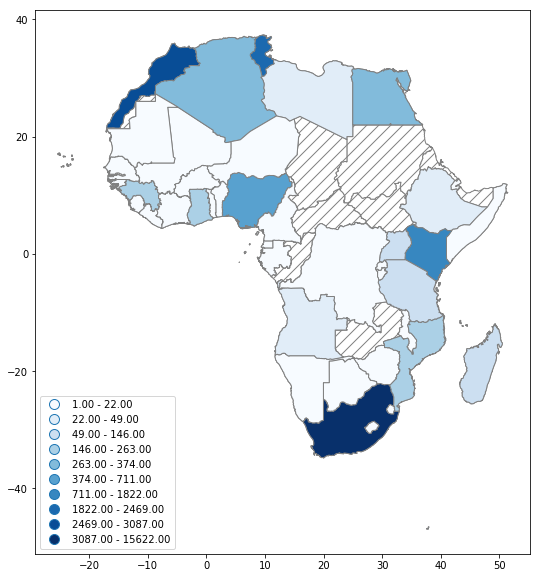

In [8]:
ax = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax = count_merged.dropna().plot(ax=ax, column='count', cmap='Blues', scheme='Fisher_Jenks', k=colors, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')


In [9]:
response = urllib2.urlopen(mlab_sites_config)
sites = json.loads(response.read())

all_metros = {}
africa_metros = {}
for row in sites:
    all_metros[row['site'][0:3]] = (geometry.Point(row['longitude'], row['latitude'], ))
    if row['site'][0:3] in african_sites:
        africa_metros[row['site'][0:3]] = all_metros[row['site'][0:3]]
    
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(all_metros, orient='index', columns=['location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(africa_metros, orient='index', columns=['location']), geometry='location')

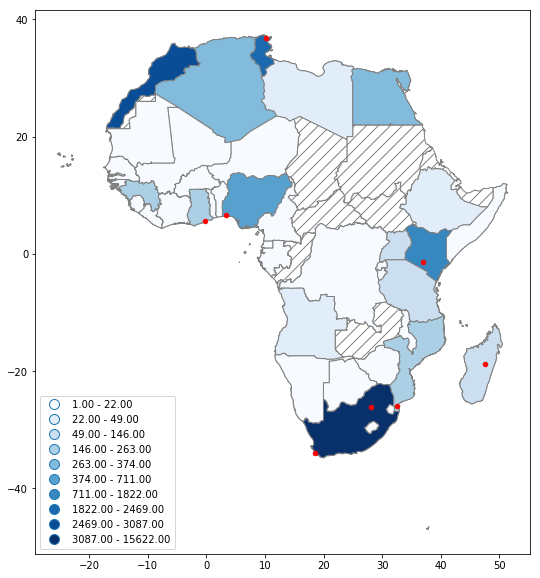

In [10]:
ax = africa.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax = count_merged.dropna().plot(ax=ax, column='count', cmap='Blues', scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
africa_locations.plot(ax=ax, color='red', markersize=20)

Text(0.5,1,'Download Rates (Mbps)')

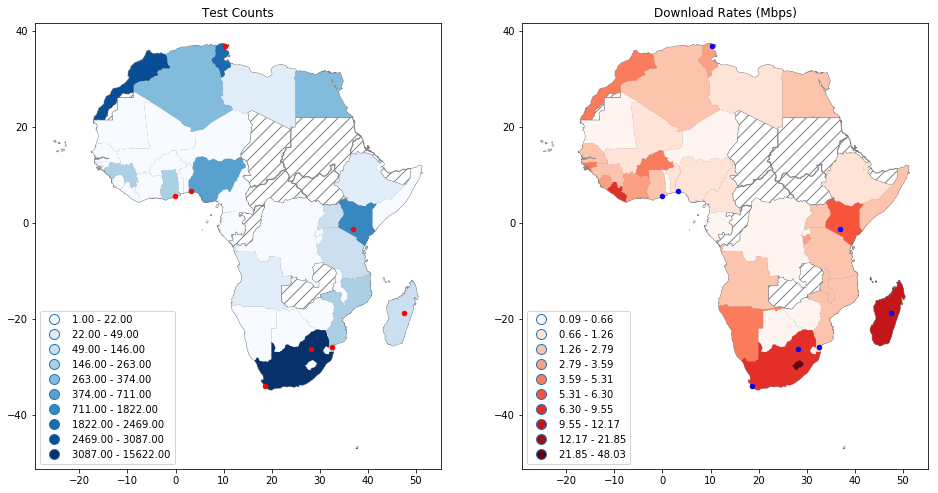

In [11]:
f, ax = plt.subplots(1, 2, figsize=figsize)

rates_merged = africa.merge(rates_df, left_on='ISO_A2', right_on='country_code')

ax0 = africa.plot(ax=ax[0], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax1 = count_merged.dropna().plot(ax=ax0, column='count', cmap='Blues', scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
africa_locations.plot(ax=ax1, color='red', markersize=20)

ax0 = africa.plot(ax=ax[1], column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")
ax2 = rates_merged.dropna().plot(ax=ax0, column='download_Mbps', cmap='Reds', scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3})
africa_locations.plot(ax=ax2, color='blue', markersize=20)

ax1.set_title('Test Counts')
ax2.set_title('Download Rates (Mbps)')

In [12]:
df_hops = {}
for site in ['jnb', 'cpt', 'mpm', 'tnr', 'nbo', 'los', 'acc', 'tun']:
    print site
    df_hops[site] = run_query("""
select 
  paris_traceroute_hop.dest_geolocation.country_code as dest_country_code,
  count(*) as hops
from
  `measurement-lab.traceroute.base`
  
where
      TIMESTAMP_TRUNC(log_time, DAY) = TIMESTAMP("2018-11-01")
  AND REGEXP_CONTAINS(test_id, r"mlab[1-4].%s\d\d")
  AND connection_spec.client_geolocation.continent_code = "AF"

GROUP BY
  dest_country_code

ORDER BY
  hops desc
""" % site)

jnb
cpt
mpm
tnr
nbo
los
acc
tun


Skipping tun


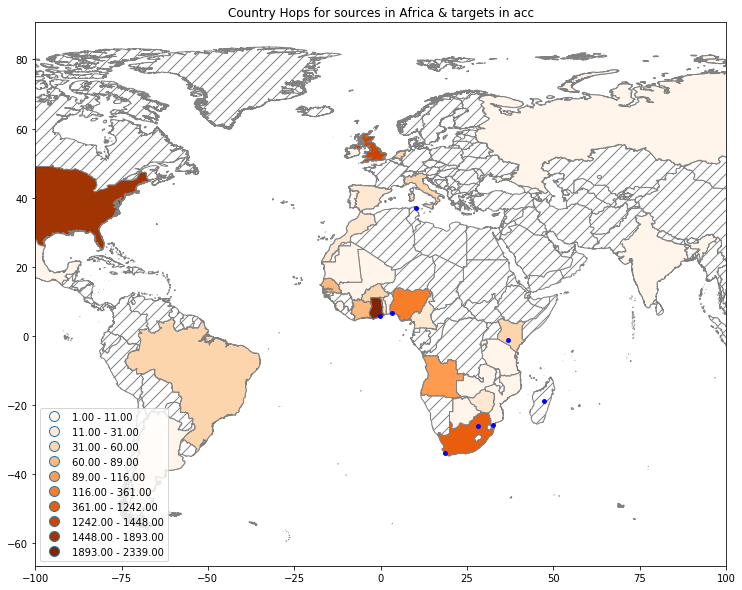

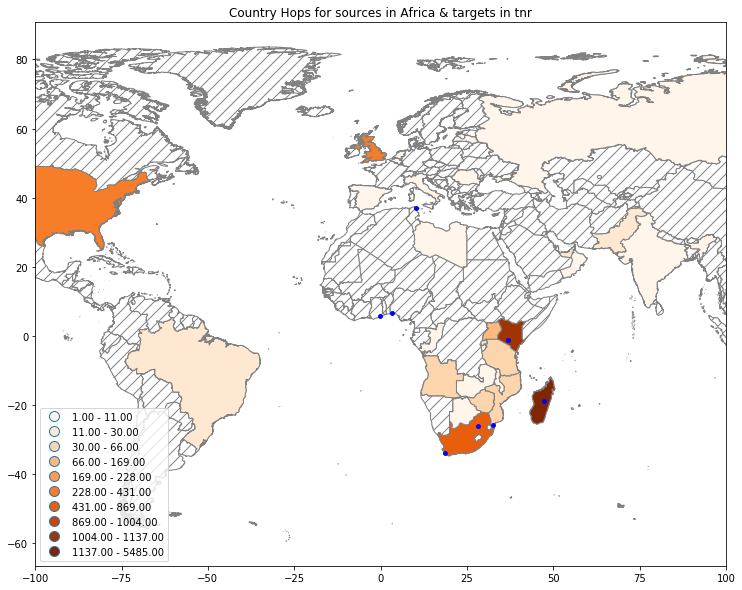

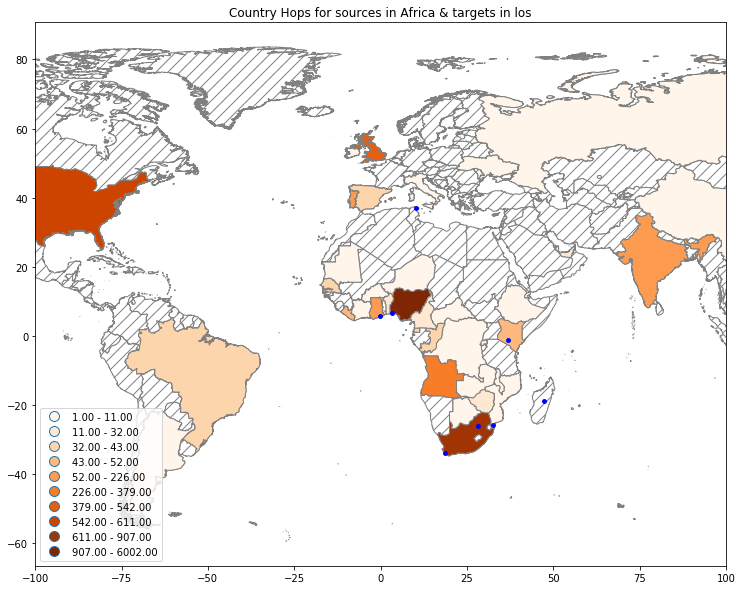

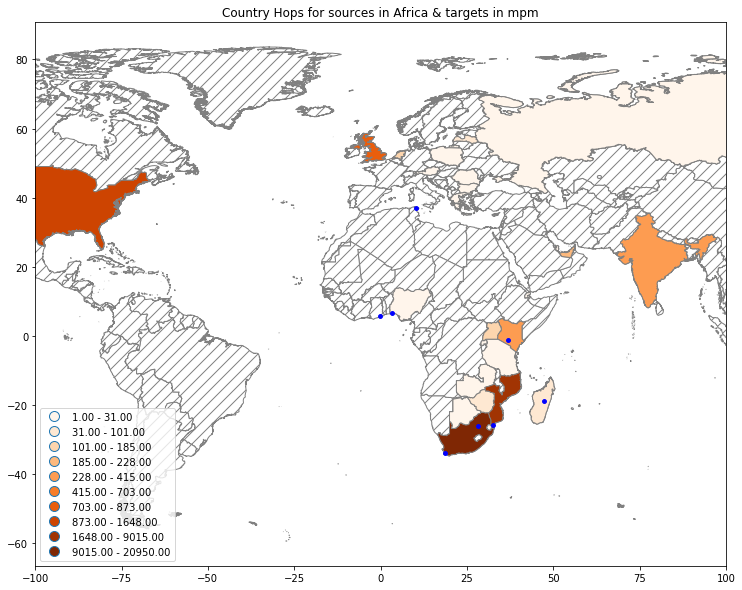

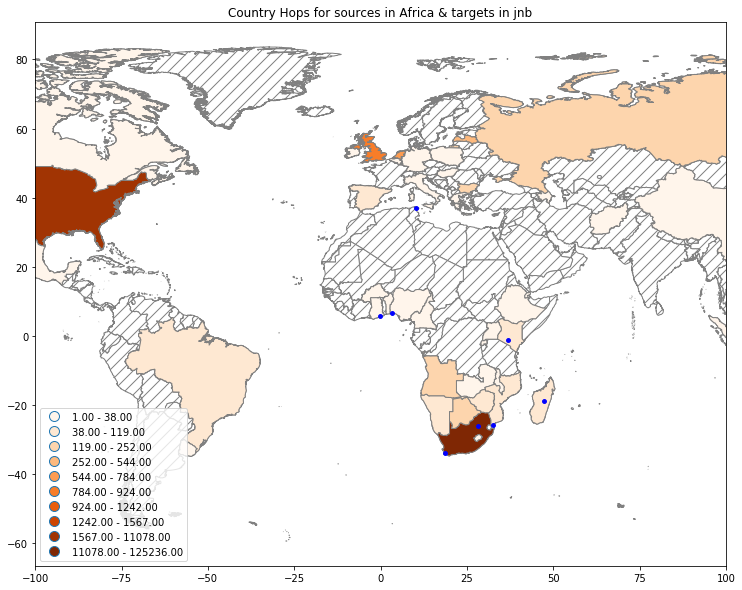

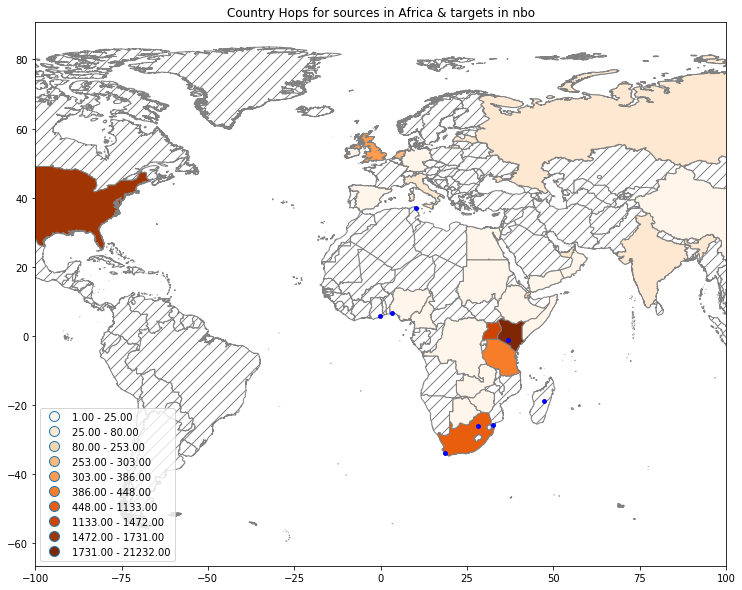

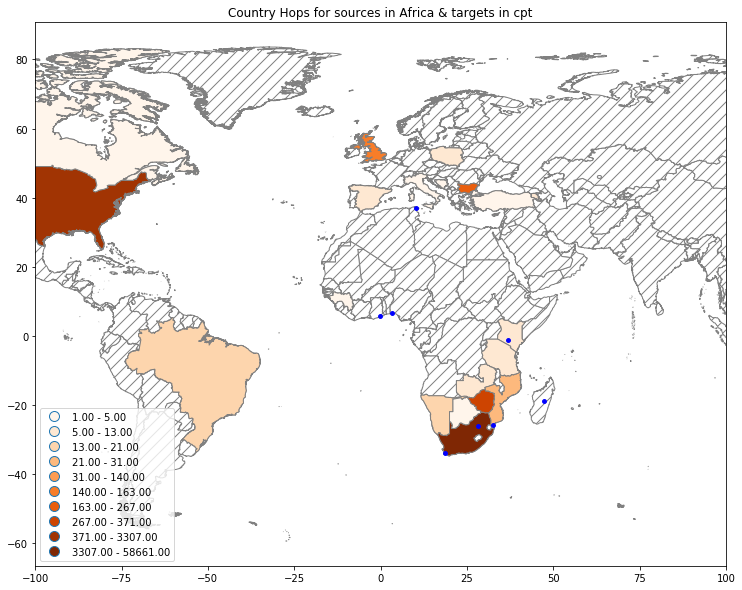

In [13]:
eu_af = globe

for site in df_hops:
    if not len(df_hops[site]):
        print "Skipping %s" % site
        continue
    ax = globe.plot(column='default', color='white', edgecolor='grey', figsize=figsize, hatch="//")

    #ax = globe.plot(column='default', color='white', figsize=(16, 16), legend=True, legend_kwds={"loc": 3}, edgecolor='black')
    hops_merged = eu_af.merge(df_hops[site], left_on='ISO_A2', right_on='dest_country_code')
    #ax1 = hops_merged.dropna().plot(column='hops', cmap='Oranges', figsize=(16,16), scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3}, edgecolor='black')
    ax1 = hops_merged.dropna().plot(ax=ax, column='hops', cmap='Oranges', scheme='Fisher_Jenks', k=10, legend=True, legend_kwds={"loc": 3}, edgecolor='grey')
    ax1.set_title('Country Hops for sources in Africa & targets in %s' % site)
    africa_locations.plot(ax=ax1, color='blue', markersize=15)
    ax1.set_xbound(-100, 100)
